# Load collected data from MindGame into useable dataframes

In [1]:
# Imports from python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json
import datetime

# Constants/Globals
CWD = "/Users/shehjarsadhu/Desktop/UniversityOfRhodeIsland/Graduate/WBL/Project_MindGame/2024-11-07"

DATA_DIR = os.path.join(CWD, "data")

WATCH_DATA_DIR = os.path.join(DATA_DIR, "watch_data")
ACC_DATA_DIR = os.path.join(WATCH_DATA_DIR, "accelerometer_data")
GYRO_DATA_DIR = os.path.join(WATCH_DATA_DIR, "gyroscope_data")
LINEAR_DATA_DIR = os.path.join(WATCH_DATA_DIR, "linear_acceleration_data")
HR_DATA_DIR = os.path.join(WATCH_DATA_DIR, "heartrate_data")

MOUSE_DATA_DIR = os.path.join(DATA_DIR, "mouse_data")
EUCLID_DATA_DIR = os.path.join(DATA_DIR, "euclid")
META_DATA_DIR = os.path.join(DATA_DIR, "level_info")





In [2]:
import os
import re

def cleanDataDirectory():
    MAX_PARTICIPANT_ID = 100
    directories = [META_DATA_DIR, ACC_DATA_DIR, GYRO_DATA_DIR, LINEAR_DATA_DIR, HR_DATA_DIR, MOUSE_DATA_DIR, EUCLID_DATA_DIR]
    
    for directory in directories:

        if os.path.exists(directory) and os.path.isdir(directory):  # Check if directory exists and is a directory
            for filename in os.listdir(directory):
                filenameRegex = re.compile(r'[NP](\d+)')
                match = filenameRegex.search(filename)

                if match:
                    userID = int(match.group(1))
                    # print(userID, type(userID))
                    
                    if userID >= MAX_PARTICIPANT_ID:
                        file_path = os.path.join(directory, filename)
                        print(file_path)
                        
                        if os.path.isfile(file_path):  # Ensure it's a file before attempting to remove it
                            os.remove(file_path)
                            print(f"Removing {file_path}")
                        else:
                            print(f"Skipping non-file {file_path}")
        else:
            print(f"Directory {directory} does not exist or is not a directory")
                    
cleanDataDirectory()     

### Load Meta Data from each level

In [3]:

def convert_time_to_seconds(time_str):
    try:
        minutes, seconds = map(int, time_str.split(':'))
        return minutes * 60 + seconds
    except ValueError:
        print(f"Invalid time format: '{time_str}'")
        return None

# Loads the meta data from each level in the data directory
# Optional parameters of users is an array of userID (strings) to only load data for
def loadMetaData(users=[]):
    metaData = []
    metaDataColumns = ["group","userID", "level", "sublevel", "timeToComplete", "timestamp", "day", "screenWidth", "screenHeight"]
    
    # Define the regex pattern to only capture the timestamp
    filenameTimestampExtractionRegex = re.compile(r'info_(?:N\d+|P\d+)_L\d+_S\d+_(\d+)\.json')

    # Loop over each file
    for filename in os.listdir(META_DATA_DIR):
        
        try:
            # Open file and load data
            with open(os.path.join(META_DATA_DIR, filename), "r") as file:
                jsonData = json.load(file)
        except Exception as e:
            print(f"Error reading file '{filename}': {e}")
            continue

        # Get timestamp from filename
        timestamp = 0
        match = filenameTimestampExtractionRegex.match(filename)
        if match:
            timestamp = match.group(1)
            # date_obj = datetime.datetime.fromtimestamp(int(timestamp))
            # print(date_obj.strftime("%c"))
            # day = date_obj.strftime("%c").split(" ")[0]
        else:
            print(f"Could not extract timestamp from '{filename}' using regex")
            continue

        # Convert timeToComplete to seconds
        timeToComplete = convert_time_to_seconds(jsonData["TimeToCompleteLevel"])
        if timeToComplete is None:
            print(f"Skipping file '{filename}' due to invalid timeToComplete format")
            continue
        
        #Check to see if we need to only include specified users
        if len(users) > 0 and jsonData["UserID"] not in users:
            continue
        
        # Add extracted data to dataframe
        metaData.append({
            "group": "N" if jsonData["UserID"][0] == "N" else "P",
            'userID': jsonData["UserID"],
            'level': int(jsonData["Level"]["main"]),
            'sublevel': int(jsonData["Level"]["sub"]),
            'timeToComplete': timeToComplete,
            'timestamp': int(timestamp),
            'day': datetime.datetime.fromtimestamp(int(timestamp)).strftime("%c").split(" ")[0],
            'screenWidth': int(jsonData["ScreenSize"]["width"]),
            'screenHeight': int(jsonData["ScreenSize"]["height"]),
            
        })
        
    return pd.DataFrame(metaData, columns=metaDataColumns)
        
        
             
# Average time to complete each level/sublevel by partcipant type two bars for each of the 27 levels        

df = loadMetaData()
df

Error reading file '.DS_Store': 'utf-8' codec can't decode byte 0xd0 in position 10: invalid continuation byte
Could not extract timestamp from 'info_NoID_L1_S1_1718510625.json' using regex


,group,userID,level,sublevel,timeToComplete,timestamp,day,screenWidth,screenHeight
0,P,P4,1,1,12,1717642604,Wed,1536,864
1,N,N4,2,1,15,1718247323,Wed,1440,900
2,P,P3,5,2,66,1718373870,Fri,1278,852
3,N,N5,4,2,54,1717001443,Wed,1280,720
4,P,P4,6,2,52,1717704686,Thu,1536,864
...,...,...,...,...,...,...,...,...,...
1920,P,P3,5,3,51,1718578223,Sun,1290,860
1921,N,N15,3,2,15,1720242632,Sat,1920,1080
1922,N,N5,5,3,38,1718216004,Wed,1280,720
1923,N,N15,1,2,12,1719593798,Fri,1920,1080


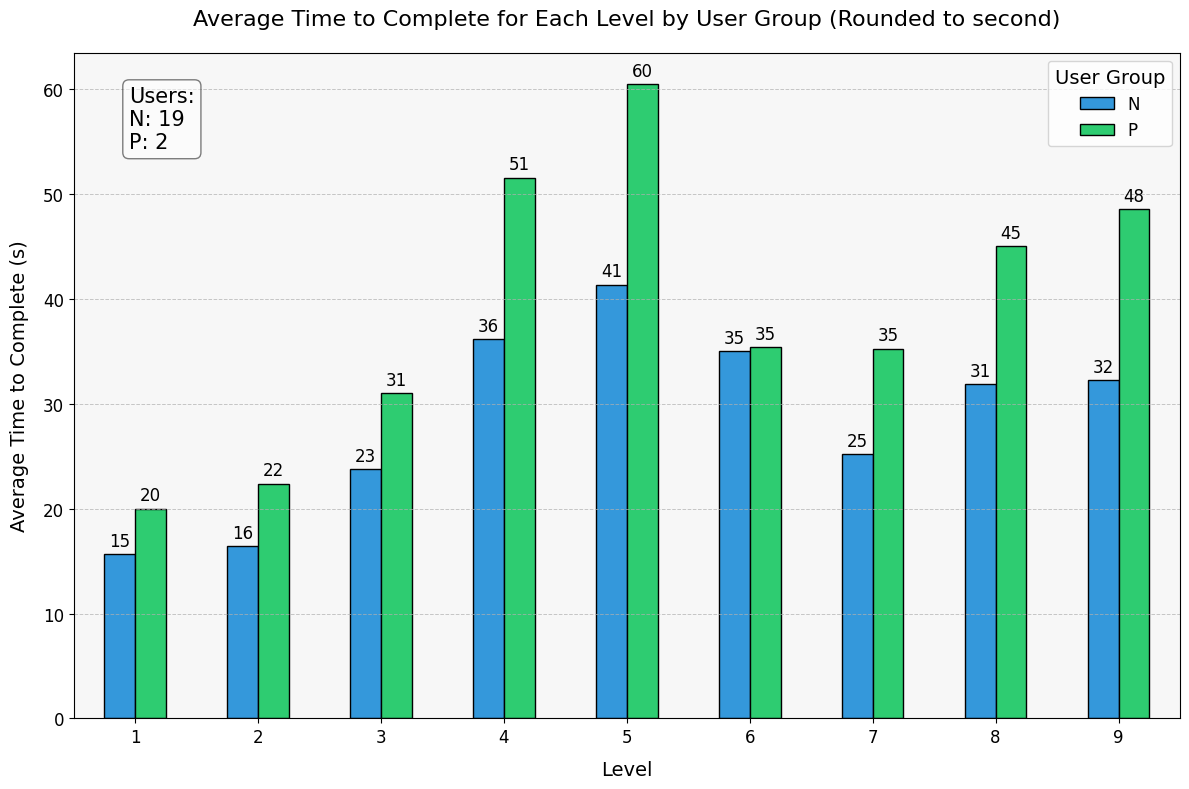

In [4]:
# Group by user group (first letter of userID) and level, then calculate the mean timeToComplete
df['userGroup'] = df['userID'].str[0]  # Extracting user group (first letter of userID)
avg_time = df.groupby(['userGroup', 'level'])['timeToComplete'].mean().unstack('userGroup')

# Calculate the number of unique users for each user group
unique_user_counts = df.drop_duplicates(subset='userID')['userGroup'].value_counts()

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
avg_time.plot(kind='bar', ax=ax, color=['#3498db', '#2ecc71'], edgecolor='black', linewidth=1)

# Customizing the plot
ax.set_xlabel('Level', fontsize=14, labelpad=10)
ax.set_ylabel('Average Time to Complete (s)', fontsize=14, labelpad=10)
ax.set_title('Average Time to Complete for Each Level by User Group (Rounded to second)', fontsize=16, pad=20)
ax.legend(title='User Group', fontsize=12, title_fontsize=14)
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Adding data labels
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=12, label_type='edge', padding=3)

# Enhancing x-axis labels
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Adding a background color
ax.set_facecolor('#f7f7f7')

# Adding the text box with unique user counts
textstr = f'Users:\nN: {unique_user_counts.get("N", 0)}\nP: {unique_user_counts.get("P", 0)}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)


# Tight layout for better spacing
plt.tight_layout()

plt.show()

/var/folders/d3/mwqwbw3x0b30c22zykpzcrww0000gn/T/ipykernel_14909/3796551288.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  day_counts = df.groupby(['day', 'userGroup']).size().unstack('userGroup', fill_value=0)


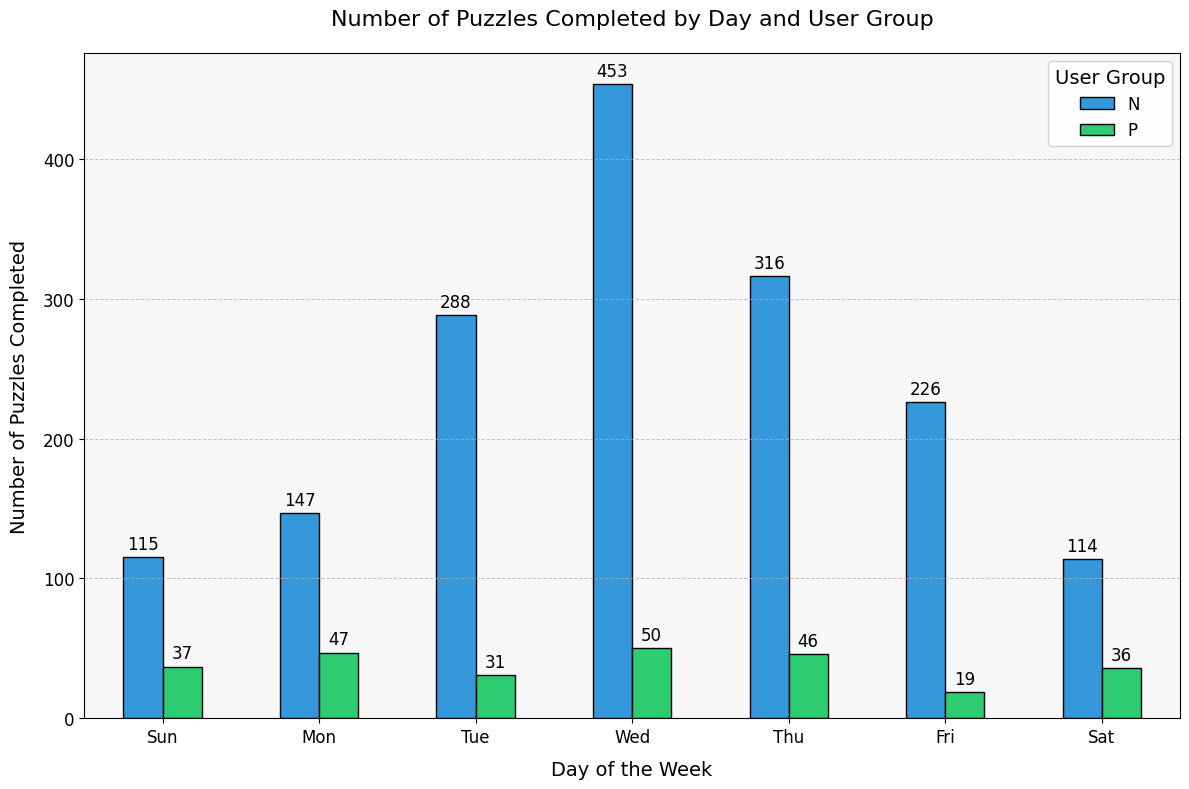

In [5]:

# Assuming 'df' is your original DataFrame
df['userGroup'] = df['userID'].str[0]  # Extracting user group (first letter of userID)

# Define the order of the days
day_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

# Convert the 'day' column to a categorical type with the defined order
df['day'] = pd.Categorical(df['day'], categories=day_order, ordered=True)

# Group by day and user group, then count the number of occurrences
day_counts = df.groupby(['day', 'userGroup']).size().unstack('userGroup', fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
day_counts.plot(kind='bar', ax=ax, color=['#3498db', '#2ecc71'], edgecolor='black', linewidth=1)

# Customizing the plot
ax.set_xlabel('Day of the Week', fontsize=14, labelpad=10)
ax.set_ylabel('Number of Puzzles Completed', fontsize=14, labelpad=10)
ax.set_title('Number of Puzzles Completed by Day and User Group', fontsize=16, pad=20)
ax.legend(title='User Group', fontsize=12, title_fontsize=14)
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Adding data labels
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=12, label_type='edge', padding=3)

# Enhancing x-axis labels
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Adding a background color
ax.set_facecolor('#f7f7f7')

# Tight layout for better spacing
plt.tight_layout()

plt.show()


In [6]:
def loadAllEuclidData(users=[]):
    euclidData = []
    euclidDataColumns = ["type", "group", "userID", "level", "sublevel", "timestamp", "shapeDistances"]
    filenameDataExtractionRegex = re.compile(r'(shortest|user)_(N\d+|P\d+)_L(\d+)_S(\d+)_(\d+)\.json')
    
    # Loop over each file
    for filename in os.listdir(EUCLID_DATA_DIR):
        match = filenameDataExtractionRegex.match(filename)
        if match == None:
            print(f"Could not extract euclid data from filename '{filename}' with regex")
            continue
        
            
        fileType = match.group(1)
        userID = match.group(2)
        level = match.group(3)
        sublevel = match.group(4)
        timestamp = match.group(5)
        
        #Check to see if we need to only include specified users
        if len(users) > 0 and userID not in users:
            continue
        
        
        try:
            # Open file and load data
            with open(os.path.join(EUCLID_DATA_DIR, filename), "r") as file:
                jsonData = json.load(file)
        except Exception as e:
            print(f"Error reading file '{filename}': {e}")
            continue
        
        
        # Add extracted data to dataframe
        euclidData.append({
            "type": fileType,
            "group": "N" if userID[0] == "N" else "P",
            'userID': userID,
            'level': int(level),
            'sublevel': int(sublevel),
            'timestamp': int(timestamp),
            "shapeDistances": jsonData,
        })
    
    allEculidData = pd.DataFrame(euclidData, columns=euclidDataColumns)
    
    # Calculate percent change between shortest and the users shapes distances
    user_df = allEculidData[allEculidData["type"] == "user"]
    shortest_df = allEculidData[allEculidData["type"] == "shortest"]
    
    for index, row in user_df.iterrows():
        
        shortestMatchingRow = shortest_df[
            (shortest_df["group"] == row["group"]) &
            (shortest_df["userID"] == row["userID"]) &
            (shortest_df["level"] == row["level"]) &
            (shortest_df["sublevel"] == row["sublevel"]) &
            (shortest_df["timestamp"] == row["timestamp"]) 
        ]
        
        if not shortestMatchingRow.empty:
            shortestShapes = shortestMatchingRow["shapeDistances"].iloc[0].keys()
            userShapes = list(row["shapeDistances"].keys())
            shapesSet = [value for value in userShapes if value in shortestShapes]
            
            averagePercentChange = 0
            
            for shape in shapesSet:
                percent_change = abs(((row["shapeDistances"][shape] - shortestMatchingRow["shapeDistances"].iloc[0][shape]) / shortestMatchingRow["shapeDistances"].iloc[0][shape]) * 100)
 
                averagePercentChange += percent_change
                
            averagePercentChange /= len(shapesSet)
            user_df.at[index, "averageOverlapPercentChange"] = round(averagePercentChange, 2)
            
            
            # Total Percent change not just the overlapping shapes
            userTotalDistance = sum(row["shapeDistances"].values())
            shortestTotalDistance = sum(shortestMatchingRow["shapeDistances"].iloc[0].values())
            totalPercentChange = abs(((userTotalDistance - shortestTotalDistance) / shortestTotalDistance * 100))
            user_df.at[index, "totalPercentChange"] = round(totalPercentChange, 2)
                                     

        else:
            print(f"Could not find matching row for shortest: timestamp={row['timestamp']}")
            continue
            
        
        
    # Clean up dataframe (remove columns that arent used)
    df['level'] = df['level'].astype(int)
    df['sublevel'] = df['sublevel'].astype(int)
    df['timestamp'] = df['timestamp'].astype(int)
    
    user_df.drop(columns=["shapeDistances", "type"], inplace=True)
    
    
        
    return user_df


    


loadAllEuclidData()


        

Could not extract euclid data from filename 'user_NoID_L1_S1_1718510625.json' with regex
Could not extract euclid data from filename 'shortest_NoID_L1_S1_1718510625.json' with regex


/var/folders/d3/mwqwbw3x0b30c22zykpzcrww0000gn/T/ipykernel_14909/3399979638.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df.at[index, "averageOverlapPercentChange"] = round(averagePercentChange, 2)
/var/folders/d3/mwqwbw3x0b30c22zykpzcrww0000gn/T/ipykernel_14909/3399979638.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df.at[index, "totalPercentChange"] = round(totalPercentChange, 2)
/var/folders/d3/mwqwbw3x0b30c22zykpzcrww0000gn/T/ipykernel_14909/3399979638.py:95: SettingWithCopyWar

,group,userID,level,sublevel,timestamp,averageOverlapPercentChange,totalPercentChange
3,N,N20,3,3,1719492250,21.56,14.48
6,N,N3,3,2,1718035746,13.53,10.13
7,N,N10,2,1,1717092364,8.11,0.19
8,N,N15,9,2,1720243080,22.42,11.81
13,N,N10,5,2,1719335507,22.36,9.04
...,...,...,...,...,...,...,...
3841,N,N11,5,1,1719328073,17.40,2.73
3842,N,N4,2,3,1716994196,12.21,5.09
3844,N,N6,1,3,1718395582,10.30,15.42
3845,N,N4,1,2,1716994104,20.67,7.40


In [7]:
def mergeMetaAndEucid(meta_df: pd.DataFrame, euclid_df: pd.DataFrame):
    merged_df = meta_df.copy(deep=True)
     
    for index, row in meta_df.iterrows():

        euclidMatchingRow =  euclid_df[
            ( euclid_df["userID"] == row["userID"]) &
            ( euclid_df["level"] == row["level"]) &
            ( euclid_df["sublevel"] == row["sublevel"]) &
            (euclid_df["timestamp"] == row["timestamp"]) 
        ]
        
        if not euclidMatchingRow.empty:
            merged_df.at[index, "averageOverlapPercentChange"] = euclidMatchingRow["averageOverlapPercentChange"].iloc[0]
            merged_df.at[index, "totalPercentChange"] = euclidMatchingRow["totalPercentChange"].iloc[0]
            
            
    
    return merged_df



merged_df = mergeMetaAndEucid(loadMetaData(), loadAllEuclidData())
merged_df.to_csv("meta_data.csv", index=False)
merged_df
    

Error reading file '.DS_Store': 'utf-8' codec can't decode byte 0xd0 in position 10: invalid continuation byte
Could not extract timestamp from 'info_NoID_L1_S1_1718510625.json' using regex
Could not extract euclid data from filename 'user_NoID_L1_S1_1718510625.json' with regex
Could not extract euclid data from filename 'shortest_NoID_L1_S1_1718510625.json' with regex


/var/folders/d3/mwqwbw3x0b30c22zykpzcrww0000gn/T/ipykernel_14909/3399979638.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df.at[index, "averageOverlapPercentChange"] = round(averagePercentChange, 2)
/var/folders/d3/mwqwbw3x0b30c22zykpzcrww0000gn/T/ipykernel_14909/3399979638.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df.at[index, "totalPercentChange"] = round(totalPercentChange, 2)
/var/folders/d3/mwqwbw3x0b30c22zykpzcrww0000gn/T/ipykernel_14909/3399979638.py:95: SettingWithCopyWar

,group,userID,level,sublevel,timeToComplete,timestamp,day,screenWidth,screenHeight,averageOverlapPercentChange,totalPercentChange
0,P,P4,1,1,12,1717642604,Wed,1536,864,4.23,2.47
1,N,N4,2,1,15,1718247323,Wed,1440,900,26.79,20.05
2,P,P3,5,2,66,1718373870,Fri,1278,852,29.61,30.38
3,N,N5,4,2,54,1717001443,Wed,1280,720,36.52,21.74
4,P,P4,6,2,52,1717704686,Thu,1536,864,4.11,0.11
...,...,...,...,...,...,...,...,...,...,...,...
1920,P,P3,5,3,51,1718578223,Sun,1290,860,20.28,23.77
1921,N,N15,3,2,15,1720242632,Sat,1920,1080,25.80,28.79
1922,N,N5,5,3,38,1718216004,Wed,1280,720,36.56,26.83
1923,N,N15,1,2,12,1719593798,Fri,1920,1080,15.56,12.81


In [8]:
merged_df["userID"].unique()

array(['P4', 'N4', 'P3', 'N5', 'N12', 'N8', 'N6', 'N14', 'N9', 'N15',
       'N20', 'N18', 'N3', 'N17', 'N10', 'N7', 'N13', 'N11', 'N19', 'N16',
       'N21'], dtype=object)

In [9]:
merged_df[merged_df["userID"] =="N6"]["level"].value_counts()

level
3    33
2    33
1    33
4    33
5    33
6    32
7    30
8    27
9    27
Name: count, dtype: int64

/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

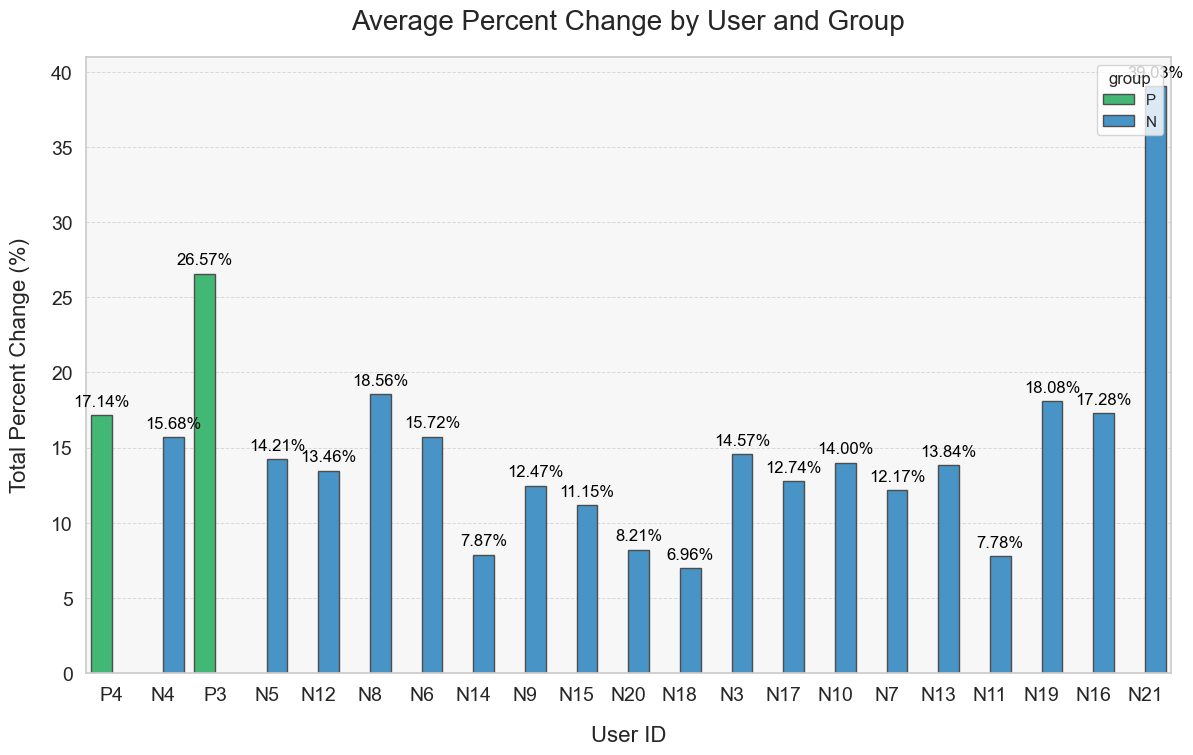

In [10]:


# Define a custom palette
custom_palette = {'N': '#3498db', 'P': '#2ecc71'}

# Plot total percent change by userID, grouped by group
sns.set(style="whitegrid")  # Set the style of the plot
plt.figure(figsize=(14, 8))  # Set the figure size
ax = sns.barplot(
    data=merged_df, x="userID", y="totalPercentChange", hue="group",
    palette=custom_palette, edgecolor=".3", errorbar=None
)

# Customize the plot
plt.title("Average Percent Change by User and Group", fontsize=20, pad=20)
plt.xlabel("User ID", fontsize=16, labelpad=15)
plt.ylabel("Total Percent Change (%)", fontsize=16, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add grid lines
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Add data labels
for p in ax.patches:
    height = p.get_height()
    if height != 0:  # Skip annotation if height is zero
        ax.annotate(f'{height:.2f}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=12, color='black',
                    xytext=(0, 10), textcoords='offset points')

# Adding a background color
ax.set_facecolor('#f7f7f7')




In [11]:
puzzle_counts

NameError: name 'puzzle_counts' is not defined

In [ ]:
# Group by userID and group, then count the total number of sublevels completed by each participant
puzzle_counts = df.groupby(['userID', 'group']).size().reset_index(name='puzzlesCompleted')


# Define a custom palette
custom_palette = {'N': '#3498db', 'P': '#2ecc71'}


# Set the figure size
plt.figure(figsize=(14, 8))

# Create the bar plot
ax = sns.barplot(
    data=puzzle_counts, x='userID', y='puzzlesCompleted', hue='group',
    palette=custom_palette, edgecolor=".3"
)

# Customize the plot
plt.title("Number of Puzzles Completed by Each Participant", fontsize=20, pad=20)
plt.xlabel("User ID", fontsize=16, labelpad=15)
plt.ylabel("Puzzles Completed", fontsize=16, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add grid lines
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Add data labels
for p in ax.patches:
    height = p.get_height()
    if height != 0:
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=12, color='black',
                    xytext=(0, 10), textcoords='offset points')

# Adding a background color
ax.set_facecolor('#f7f7f7')


In [ ]:
import seaborn as sns

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=merged_df, x='timeToComplete', y='averageOverlapPercentChange', hue='group', palette=['#3498db', '#2ecc71'], ax=ax)

# Customizing the plot
ax.set_xlabel('Time to Complete (s)', fontsize=14, labelpad=10)
ax.set_ylabel('Average Overlap Percent Change (%)', fontsize=14, labelpad=10)
ax.set_title('Time to Complete vs Average Overlap Percent Change', fontsize=16, pad=20)
ax.grid(axis='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Enhancing axis labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding a background color
ax.set_facecolor('#f7f7f7')

# Tight layout for better spacing
plt.tight_layout()

plt.show()
